## Tutorial: N-body simulations of electrospray thruster plumes

The goal of this tutorial is to walk you through the code that simulates the expansion of the plume of an electrospray thruster. 

To simulate the expansion of the plume we need:

1- **The initial conditions of emission** (type of emitted molecules, location of emission, and velocity of emission)

2- **The definition of the external electric field** applied by the extractor grid to extract the molecules from the tip of the meniscus.

3- **A fragmentation model** to describe how complex molecules (dimers and trimers) fragment into smaller molecules (neutrals and monomers).

4- **An algorithm that computes the forces** applied on each particle within the plume at each time step.

5- **An algorithm that updates the positions** of each particle from time step t to time step t+1.

6- **A visualization tool** to visualize the propagation of the particles.

 

-----


We need to install the following packages: Numpy, Pandas, Matplotlib, nbformat, Plotly, and Numba.

Uncomment to install your missing packages and comment again. 

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install plotly
# !pip install nbformat>=4.2.0
# !pip install numba

First, Let's import the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import os
import plotly.graph_objects as go


## 1- Initial conditions of emission

We need to import the file ''emission_profile.csv''. This file contains 5 columns:

- Col 1: probability of emission at a given location $\rightarrow$ $P(r_i,z_i)$
- Col 2: radial coordinate of the emission position $\rightarrow$ $r_i$
- Col 3: axial coordinate of the emission position $\rightarrow$ $z_i$
- Col 4: radial coordinate of the emission velocity $\rightarrow$ $v_{r,i}$
- Col 5: axial coordinate of the emission velocity $\rightarrow$ $v_{z,i}$

The subscript $i$ stands for $initial$.

Credit: The emission profile comes from the electrohydrodynamic simulations of Ximo Cidoncha. 

In [3]:
df = pd.read_csv('emission_profile.csv')
prob=df.values[:,0] # probability density of emission prob=prob(ri,zi)
ri=df.values[:,1] # radial coordinate of the emission position
zi=df.values[:,2] # axial coordinate of the emission position
vri=df.values[:,3] # radial coordinate of the emission velocity
vzi=df.values[:,4] # axial coordinate of the emission velocity
vabs_i = np.sqrt(vri**2 + vzi**2) # absolute velocity
norm_prob= prob*1/np.sum(prob) # normalized probability of emission

The next section of the code produces 5 plots:

- Probability of emission vs $r_i$.
- Radial velocity $v_{r,i}$ vs $r_i$.
- Axial velocity $v_{z,i}$ vs $r_i$.
- Absolute velocity $|v|$ vs $r_i$.
- The meniscus profile $z_i$ vs $r_i$.

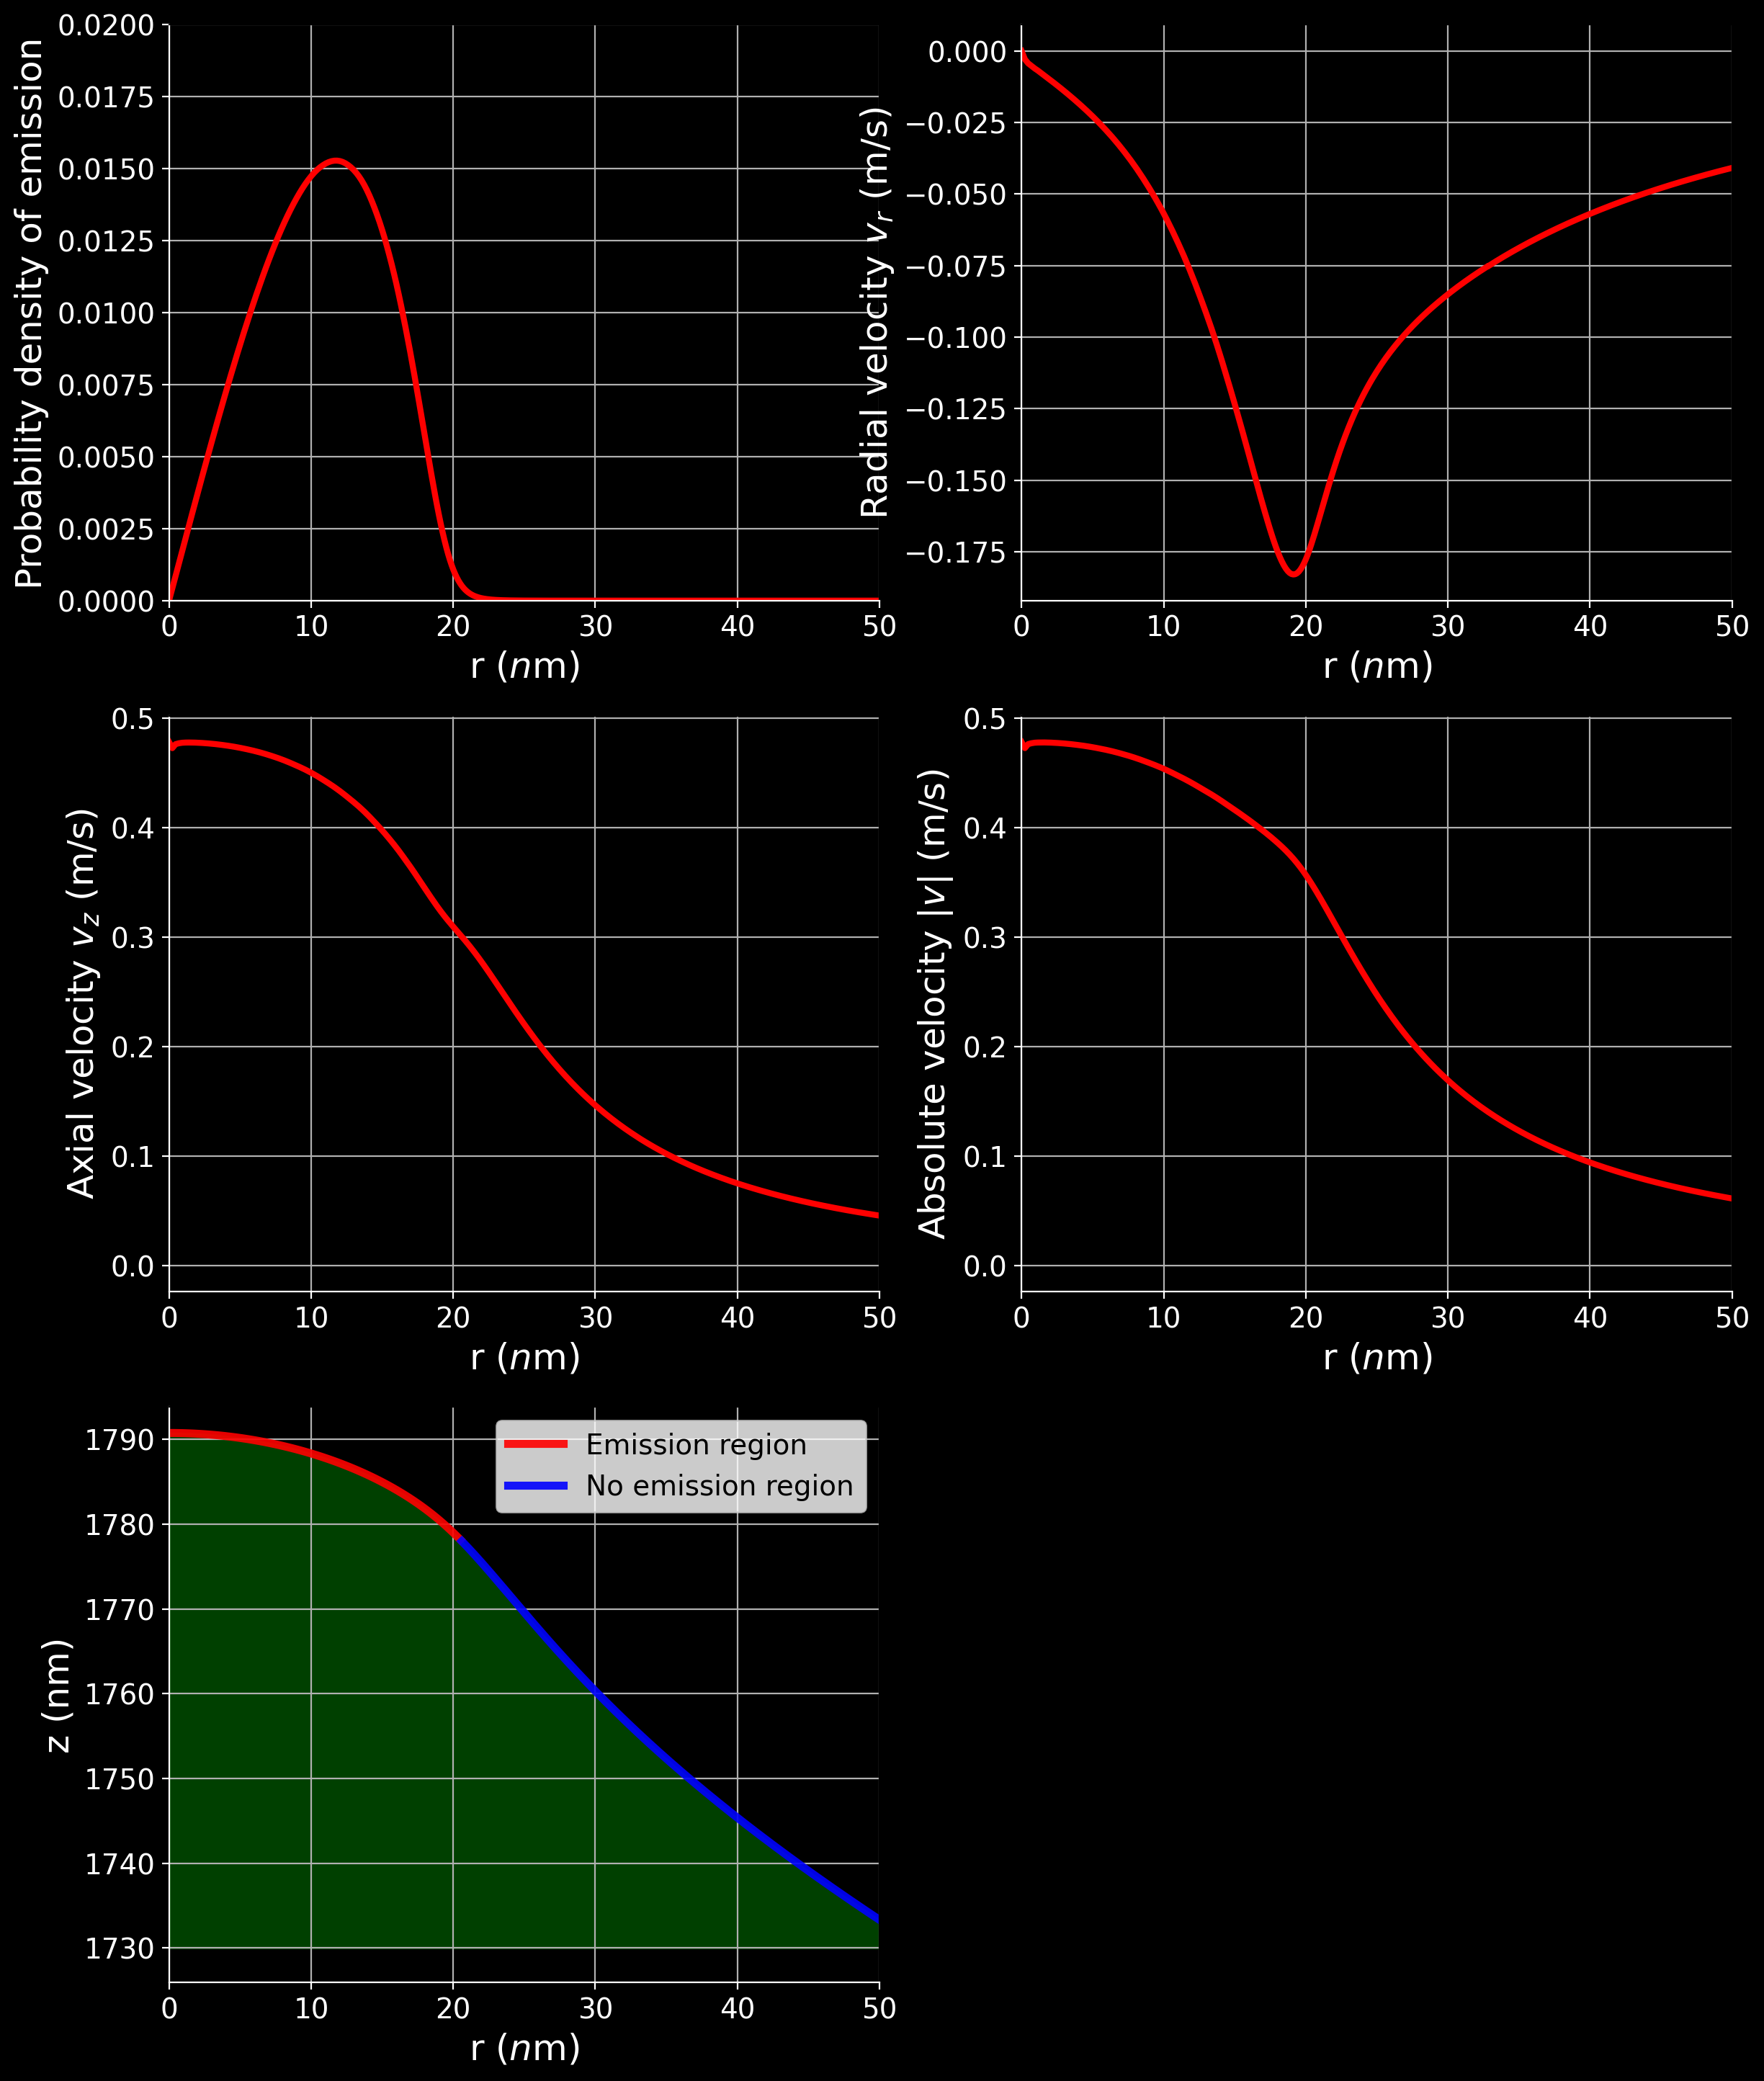

In [4]:
fig = plt.figure(figsize=(14,18), facecolor='k',dpi=200)

# Plot #1: P vs ri
ax = fig.add_subplot(321, facecolor='k')
ax.set_xlim([0, 50])
ax.set_ylim([0, 0.02])
ax.plot(ri*1e9,norm_prob,'r',linewidth=3)
# Set plot title and labels
ax.set_xlabel('r ($n$m)', size=18, color='w')
ax.set_ylabel('Probability density of emission', size=18, color='w')
ax.tick_params(axis='x', colors='w', labelsize=14)  # Increase x-tick label size
ax.tick_params(axis='y', colors='w', labelsize=14)  # Increase y-tick label size
ax.grid(True)
# Change the color of the axis spines to white
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')

# Plot #2: vri vs ri
ax = fig.add_subplot(322, facecolor='k')
ax.set_xlim([0, 50])
#ax.set_ylim([0, 0.02])
ax.plot(ri*1e9,vri,'r',linewidth=3)
# Set plot title and labels
ax.set_xlabel('r ($n$m)', size=18, color='w')
ax.set_ylabel('Radial velocity $v_r$ (m/s)', size=18, color='w')
ax.tick_params(axis='x', colors='w', labelsize=14)  # Increase x-tick label size
ax.tick_params(axis='y', colors='w', labelsize=14)  # Increase y-tick label size
ax.grid(True)
# Change the color of the axis spines to white
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')



# Plot #3: vzi vs ri
ax = fig.add_subplot(323, facecolor='k')
ax.set_xlim([0, 50])
#ax.set_ylim([0, 0.02])
ax.plot(ri*1e9,vzi,'r',linewidth=3)
# Set plot title and labels
ax.set_xlabel('r ($n$m)', size=18, color='w')
ax.set_ylabel('Axial velocity $v_z$ (m/s)', size=18, color='w')
ax.tick_params(axis='x', colors='w', labelsize=14)  # Increase x-tick label size
ax.tick_params(axis='y', colors='w', labelsize=14)  # Increase y-tick label size
ax.grid(True)
# Change the color of the axis spines to white
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')


# Plot #4: |v| vs ri
ax = fig.add_subplot(324, facecolor='k')
ax.set_xlim([0, 50])
#ax.set_ylim([0, 0.02])
ax.plot(ri*1e9,vabs_i,'r',linewidth=3)
# Set plot title and labels
ax.set_xlabel('r ($n$m)', size=18, color='w')
ax.set_ylabel('Absolute velocity $|v|$ (m/s)', size=18, color='w')
ax.tick_params(axis='x', colors='w', labelsize=14)  # Increase x-tick label size
ax.tick_params(axis='y', colors='w', labelsize=14)  # Increase y-tick label size
ax.grid(True)
# Change the color of the axis spines to white
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')

# Plot #5: zi vs ri
ax = fig.add_subplot(325, facecolor='k')
ax.set_xlim([0, 50])
#ax.set_ylim([0, 0.02])
ax.plot(ri[0:110]*1e9, zi[0:110]*1e9, 'r-',alpha=0.9,linewidth=4,label="Emission region")
ax.plot(ri[110:425]*1e9, zi[110:425]*1e9, 'b-',alpha=0.9,linewidth=4,label="No emission region")
plt.fill_between(ri[0:420]*1e9, zi[0:420]*1e9,1730, color='g', alpha=0.5)
# Set plot title and labels
ax.set_xlabel('r ($n$m)', size=18, color='w')
ax.set_ylabel('z (nm)', size=18, color='w')
ax.tick_params(axis='x', colors='w', labelsize=14)  # Increase x-tick label size
ax.tick_params(axis='y', colors='w', labelsize=14)  # Increase y-tick label size
ax.grid(True)
plt.legend(fontsize=14)
# Change the color of the axis spines to white
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')

plt.savefig("initial_condition.png", format='png', bbox_inches='tight')


Next, we define the function "IC_conditions" that randomly selects n emission points according to the given probability distribution of emission, and selects the species to be emitted from each emission point according to the probability of emitting monomers, dimers, and trimers.

In [5]:
def IC_conditions (n,prob,ri,zi,vri,vzi,Pneut,Pmono,Pdim,Ptrim):
    """
    This function selects n locations of emission based on the probability density of emission. 
    Then, it selects the species to be emitted at each given location based on the probability of emission of each species (Pneut, Pmono, Pdim, and Ptrim). 

    Args:
        n (_int_): number of emitted molecules
        prob (_np.array_): probability density of emission
        ri (_np.array_): radial coordinates of the emission position
        zi (_np.array_): axial coordinates of the emission position
        vri (_np.array_): radial coordinates of the emission velocity
        vzi (_np.array_): axial coordinates of the emission velocity
        Pneut (_float_): Probability of emitting neutrals (could be set to 0)
        Pmono (_float_): Probability of emitting monomers
        Pdim (_float_): Probability of emitting dimers
        Ptrim (_float_): Probability of emitting trimes 
        
        
    Returns:
        IC (_np.array_): nx9 array called IC where,
                        columns 0-2: represent the x,y,z coordinates of the emitted molecules
                        columns 3-5: represent the vx,vy,vz velocities of the emitted molecules
                        column 6: represents the species of the emitted molecules  # Neutrals-->0 ; Monomers-->1, dimers -->2 ; Trimers -->3
                        column 7: represents the mass of the emitted molecules
                        column 8: represents the charge the emitted molecules
    """
    
    def injection_conditions(n,prob,ri,zi,vri,vzi):
        probabilities = prob / prob.sum()
        np.random.seed(123)    # set the random number generator seed
        indices = np.random.choice(np.arange(len(probabilities)), size=n, p=probabilities) # Indices are distributes based on prob
        theta_i=np.random.uniform(0, 2*np.pi, np.size(indices)) # The angle is uniformly distributed
        x=ri[indices]*np.cos(theta_i)
        y=ri[indices]*np.sin(theta_i)
        z=zi[indices]
        vx=vri[indices]*np.cos(theta_i)
        vy=vri[indices]*np.sin(theta_i)
        vz=vzi[indices] 
        init_posvel=np.column_stack((x,y,z,vx,vy,vz))
        return init_posvel
    
    
    def species(n,Pneut,Pmono,Pdim,Ptrim):
    
        # Neutrals-->0 ; Monomers-->1, dimers -->2 ; Trimers -->3
        particles = np.array([0, 1, 2, 3]) 
        probabilities = np.array([Pmono, Pdim, Ptrim, Pneut])  
        # Normalizing probabilities (making sure they add up to 1)
        probabilities = probabilities / probabilities.sum()
        # Generate the array
        particle_types = np.random.choice(particles, size=n, p=probabilities)
        
        return particle_types
    

    amu2kg= 1.66053906660 *1e-27 # converts amu to kg
    e2C= 1.602176634 *1e-19 # converts electron charge to Coulomb
    init_posvel=injection_conditions(n,prob,ri,zi,vri,vzi)
    particle_types=species(n,Pneut,Pmono,Pdim,Ptrim)
    charges=np.sign(particle_types)*e2C
    mass_list=np.array([197.973,111.168,309.141,507.114])*amu2kg  # mass in kg: neutral, monomer, dimer, trimer 
    masses=np.array([[mass_list[i] for i in list(particle_types)]]).T  # mass of the entire set of particles
    IC=np.column_stack(( init_posvel,particle_types,masses,charges))
    return IC


In [6]:
n=10000  # Total number of emitted molecules
Pneut=0  # Percentage of neutrals at emission
Pmono=40 # Percentage of monomers at emission
Pdim=40  # Percentage of dimers at emission
Ptrim=10 # Percentage of trimers at emission

The following section of the code produces and interactive plot representing the molecules to be emitted.

Note: the code allows the emission of neutrals by varying $P_{neut}$, even though this quantity is generally set to 0.

In [7]:
IC=IC_conditions (n,prob,ri,zi,vri,vzi,Pneut,Pmono,Pdim,Ptrim)
pos=IC[:,0:3]
vel=IC[:,3:6]
species=IC[:,6]
mass=IC[:,7]
charge=IC[:,8]

# Assuming xpos, ypos, and zpos are defined similarly to x, y, and z
xpos = pos[:,0]  # x-coordinate
ypos = pos[:,1]  # y-coordinate
zpos = pos[:,2]  # z-coordinate

# Define your color and size arrays
colors = ['black', 'red', 'green', 'blue']
sizes = [1.5, 1, 2.5, 4]
species_names = ["Neutral", "Monomer", "Dimer", "Trimer"]
opacities = [0.4,0.4,.4,.1]

# Initiate an empty data list
data = []

# Create a separate trace for each species type
for i in range(4):
    indices = [j for j, x in enumerate(species) if x == i]  # indices of each species type
    trace = go.Scatter3d(
        x=[xpos[j] for j in indices],
        y=[ypos[j] for j in indices],
        z=[zpos[j] for j in indices],
        mode='markers',
        marker=dict(
            size=sizes[i],
            color=colors[i],       # Set color
            opacity=opacities[i]
        ),
        hoverinfo='none',
        showlegend=False  # We don't want to show these in the legend
    )
    data.append(trace)

    # Invisible traces for larger legend markers
    trace_legend = go.Scatter3d(
        x=[None],
        y=[None],
        z=[None],
        mode='markers',
        marker=dict(
            size=sizes[i],
            color=colors[i],
            opacity=1
        ),
        name=species_names[i],  # The name now reflects the species name
        legendgroup=species_names[i],
        showlegend=True
    )
    data.append(trace_legend)

# Create a surface below your scatter plot
x_range = np.linspace(min(xpos), max(xpos), 10)
y_range = np.linspace(min(ypos), max(ypos), 10)
x_grid, y_grid = np.meshgrid(x_range, y_range)
z_value = min(zpos)  # set your z value to be the minimum z-value
surface = go.Surface(x=x_grid, y=y_grid, z=z_value*np.ones_like(x_grid), colorscale=[[0, 'grey'], [1, 'grey']], showscale=False, opacity=0.5)
data.append(surface)

# Create a figure
fig = go.Figure(data=data)

# Set labels and set z-axis range
fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z',
                    zaxis_range=[min(zpos),max(zpos)]),  # Set the range of z-axis
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))

fig.show()



----


## 2- External electric field

We need to import the file "Fields.csv" that contains the description of the external electric field. This file contains 4 columns:
- Col 1: $r$ coordinate within the simulation domain
- Col 2: $z$ coordinate within the simulation domain
- Col 3: $E_r$ radial component of the electric field $E_r=E_r(r,z)$
- Col 4: $E_z$ axial component of the electric field $E_z=E_z(r,z)$



However, these values are given in some normalized form that needs to be converted to metric units. Thus, we import "info.txt" that contains the coefficients to convert distances to meter, velocities to m/s, and the electric field to V/m, (and contains other parameters that are not relevent to this tutorial).


Credit: The description of the external electric field comes from the electrohydrodynamic simulations of Ximo Cidoncha. 



In [8]:
# Fields.csv
# r  |  z  |  Er | Ez
# Electric current = info[0] 
# Distance scaling to meter =  info[1] 
# Electric Field (Er, Ez) scaling to V/m = info[2]
# Velocity scaling to m/s =  info[3];
# Extractor voltage = info[6]; 

#EXTRACTOR_DIST = info[10]; //extractor distance
#EXTRACTOR_APETURE_DIA = info[11]; //extractor width
#EXTRACTOR_THICKNESS = info[12]; //extractor thickness


info = np.loadtxt('info.txt')
convert_dist=info[1] # coefficient to convert distance to meter
convert_E=info[2] # coefficient to convert electric field to  V/m
convert_vel=info[3] # coefficient to convert velocity to m/s

# Load the csv file that describes the electric field
df = pd.read_csv('Fields.csv')
Field = df.values
r=Field[:,0]*convert_dist # r coordinate within the simulation domain 
z=Field[:,1]*convert_dist # z coordinate within the simulation domain 
Er=Field[:,2]*convert_E # radial component of the electric field Er=Er(r,z)
Ez=Field[:,3]*convert_E # axial component of the electric field Ez=Ez(r,z)
E = np.sqrt(Er**2 + Ez**2) # absolute value of the electric field

The following section of the code produces a plot of the magnitude of the electric field, and shows the emitter tip.

The emitter tip geometry is taken from Petro et al. (https://doi.org/10.1063/5.0065615).

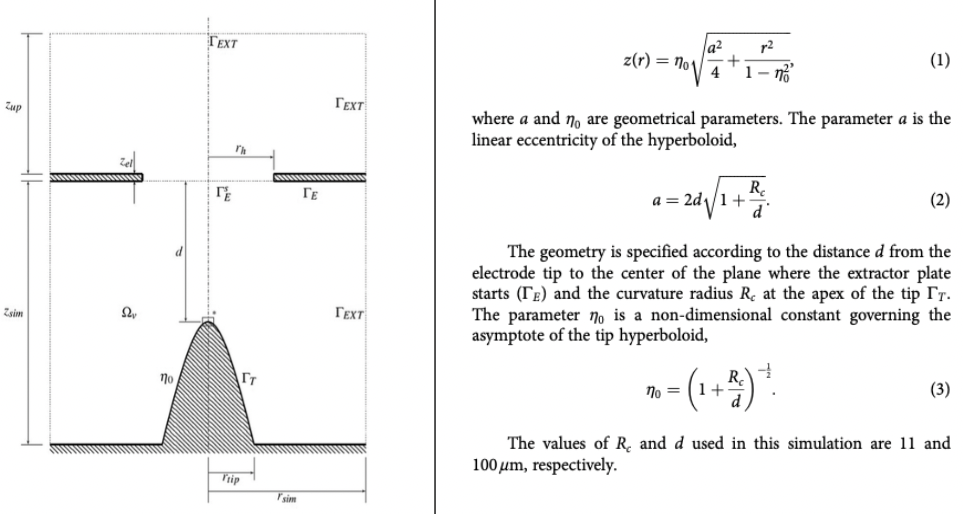

In [9]:
from IPython.display import Image
Image('emitter.png')

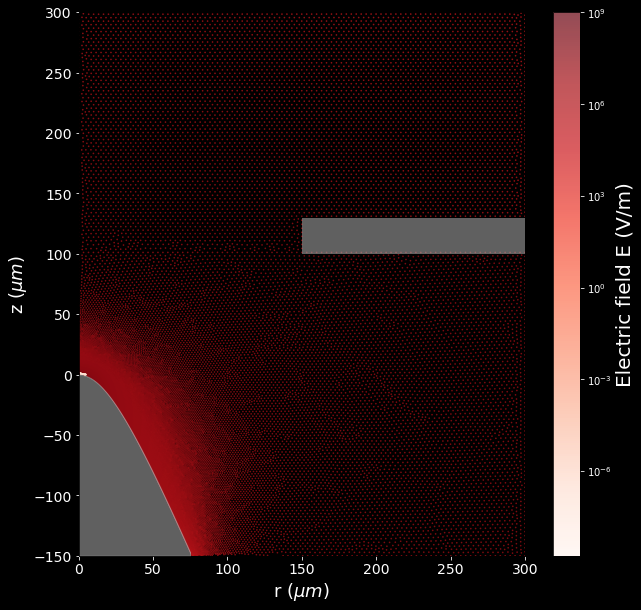

In [10]:
# Create a new figure with a black background
fig = plt.figure(figsize=(10,10), facecolor='k')
ax = fig.add_subplot(111, facecolor='k')

# Create a scatter plot
sc = ax.scatter(r*1e6, z*1e6, c=E, s=0.5, cmap='Reds', norm=LogNorm(),alpha=0.7)

# Set the x and y limits to the minimum and maximum of the data
ax.set_xlim([r.min()*1e6, r.max()*1e6])
#ax.set_ylim([z.min()*1e6, z.max()*1e6])
ax.set_ylim([z.min()*1e6, 300])

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Electric field E (V/m)', size=20, color='w')
cbar.ax.yaxis.set_tick_params(color='w')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')

# Set plot title and labels
#ax.set_title('Electric field distribution', size=20, color='w')
ax.set_xlabel('r ($\mu m$)', size=18, color='w')
ax.set_ylabel('z ($\mu m$)', size=18, color='w')
ax.tick_params(axis='x', colors='w', labelsize=14)  # Increase x-tick label size
ax.tick_params(axis='y', colors='w', labelsize=14)  # Increase y-tick label size


#Plot the grid surface
#gold = image.imread('gold.jpg')

# Define the 4 points of the rectangle
p1 = (150, 100)
p2 = (150, 130)
p3 = (300, 100)
p4 = (300, 130)
width = p3[0]-p1[0]
height = p2[1]-p1[1]
# patches.Rectangle() needs the bottom left point, width and height
rect = patches.Rectangle((p1[0],p1[1]), width, height, facecolor ='silver', alpha=0.5)
# Add the patch to the Axes
ax.add_patch(rect)
#ax.imshow(gold, extent=(p1[0], p3[0], p1[1], p2[1]), aspect='auto')

#Plot the tip of the emitter
r_tip=np.arange(0,75,0.1)
d=100
Rc=11
eta0=np.power(1+Rc/d,-1/2)
a=2*d*np.sqrt(1+Rc/d)
z_tip=100-eta0*np.sqrt(np.power(a,2)/4+np.power(r_tip,2)/(1-np.power(eta0,2)))
plt.fill_between(r_tip, z_tip,-150, color='silver', alpha=0.5)



# Show the plot
plt.savefig("E_field.png", format='png', bbox_inches='tight')
plt.show()



The electric field is only defined at a fixed number of points in space. The grid is refined near the emitter tip and gets coarser away from the tip (as shown in the figure above). However, to propagate the particles in the plume we to need to know the electric field at the location of each particle in the space. Thus, we need to interpolate the electric field at each timestep of the simulation.

We will use **Delaunay interpolation** to do the interpolation.
Delaunay interpolation gives us a set of tirangles that connect all the points without overlap, and it maximizes the minimum angle of all the angles of the triangles in the triangulation. This uniformity is beneficial for interpolation because it can minimize interpolation errors and ensure more accurate results.

We only need to construct the Delaunay triangles once (at the first time step), which is the most expensive part of the algorithm. Then, we will use the same set of triangles to do the interpolation for the rest of the simulation.


(A good explanation and visualization of Delaunay interpolation here: https://www.youtube.com/watch?v=jxOAU7YfypA)

The following section of the code contains the implementation of the Delaunay interpolation that will be used later in the main simulation function.


In [11]:
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator


def triangulation (r,z,Er,Ez):
    """Performs Delaunay-based linear interpolation of electric field components in a two-dimensional domain.
    This function takes arrays of radial and axial coordinates (r, z), along with corresponding arrays of radial (Er) and axial (Ez) electric field components.
    
    Args:
    - r: An array of radial coordinates.
    - z: An array of axial coordinates.
    - Er: An array of radial electric field components corresponding to the points defined by `r` and `z`.
    - Ez: An array of axial electric field components corresponding to the points defined by `r` and `z`.
    
    Returns:
    - interp: A callable object (LinearNDInterpolator instance) that can be used to find interpolated electric field values (Er, Ez) at any given point (r, z)
                within the domain covered by the input arrays.
    """
    points = np.column_stack((r, z))
    tri = Delaunay(points)
    E_array= np.vstack((Er.flatten(), Ez.flatten())).T
    interp=LinearNDInterpolator(tri, E_array, fill_value=np.nan, rescale=False)
    return interp


def interp_lin_delaunay(interp,request_pts):
    """Interpolates electric field values at requested points using a precomputed Delaunay interpolation object.

    Args:
        interp (LinearNDInterpolator): An instance of scipy.interpolate.LinearNDInterpolator that represents 
        a precomputed Delaunay-based interpolation scheme for a set of spatial data points and their corresponding values.
        
        request_pts (np.array): Coordinates of the points where electric field values are to be interpolated. 

    Returns:
        An array of interpolated electric field values at the requested points. (nx2 array of Er and Ez)
    """
    
    return interp(request_pts)


def compute_efield (interp,pos):
    """Computes the electric field values at specified positions using a precomputed Delaunay interpolation object.
    It converts Cartesian coordinates (x, y, z) to cylindrical coordinates (r, z) to interpolate
    electric field values using a given Delaunay interpolation scheme.

    Args:
        interp (LinearNDInterpolator): An instance of scipy.interpolate.LinearNDInterpolator that represents 
        a precomputed Delaunay-based interpolation scheme for a set of spatial data points and their corresponding values.
        
        pos (np.array): An array of positions in Cartesian coordinates where the electric field values are
        to be computed. The array shape should be (n, 3), where n is the number of points, and each row
        corresponds to the (x, y, z) coordinates of a point.

    Returns:
        E_array(np.array): An array of interpolated electric field values at the requested positions. The array shape
        is (n, 2), where n is the number of points, and each row contains the interpolated radial (Er) and
        axial (Ez) electric field components.
    """
    x = pos[:,0].copy()
    y = pos[:,1].copy()
    z = pos[:,2].copy()
    r = np.sqrt(x**2 + y**2) # convert cartesian to cylindrical
    request_pts=np.vstack((r,z)).T
    E_array=interp_lin_delaunay(interp,request_pts) # nx2 array of Er and Ez
    return E_array




----

## 3- Fragmentation model

When being emitted, complex molecules (trimers and dimers) fragment into smaller molecules. There are 3 types of fragmentation:
- Trimer $\rightarrow$ Secondary Dimer + Neutral
- Secondary Dimer $\rightarrow$ Secondary Monomer + Neutral
- Primary Dimer  $\rightarrow$ Secondary Monomer + Neutral

The fragmentation model is taken from Schroeder et al (https://doi.org/10.1063/5.0146830).

The mean life time of molecules is modeled witha polynomial: $\tau=c_3 |E|^3 +c_2 |E|^2+c_1|E|+c_0$.

The probability of fragmentation is given by: $P=1-e^{-dt/ \tau}$.


Neutrals, primary monomers, and secondary monomers do not fragment ($\tau \rightarrow \infty$).

Trimers, primary dimers, and secondary dimers have differnet coefficients ($c_3$, $c_2$, $c_1$, and $c_0$).

We use the following encoding: 
- Neutrals $\rightarrow 0$
- Primary Monomer $\rightarrow$ 1
- Primary Dimer $\rightarrow$ 2
- Primary Trimer $\rightarrow$ 3
- Secondary Monomer $\rightarrow$ 4
- Secondary Dimer $\rightarrow$ 5


In [12]:

def prob_frag_compute(species,E_mag,dt):
    
    """Computes the lifetime and fragmentation probability for different molecular species.

   
    Args:
        species (np.array): A 1D array of integers representing different molecular species, where
                            0=Neutrals, 1=Primary Monomer, 2=Primary Dimer, 3=Primary Trimer,
                            4=Secondary Monomer, 5=Secondary Dimer.
        E_mag (np.array): A 1D array of the same length as `species`, representing the magnitude of the
                          electric field at the locations of the respective species.
        dt (float): The timestep over which the fragmentation probability is calculated.

    Returns:
        lifetime,frag: A tuple containing two arrays of the same shape as `species`. The first array represents
               the lifetime of each species before fragmentation, and the second array represents the
               probability of fragmentation within the timestep `dt`.
    """

    
    
    # Ensure species is a contiguous 1D array (cheap operation)
    assert species.shape[1] == 1
    contig_species = species[:,0].copy()
    
    frag=np.zeros_like(contig_species)
    lifetime=np.zeros_like(contig_species)
    
    for i in range(len(contig_species)):
        
        spec=contig_species[i]
        
        if spec==0 or spec==1 or spec==4:
            #Neutral or Primary Monomer or Secondary Monomer
            tau=np.inf
        
        elif spec==2:
            #Primary Dimer
            c3= -8.3172e-29
            c2= 1.267e-18
            c1= -6.108e-09
            c0= 9.2724
            tau=np.exp(c3*E_mag[i]**3 + c2*E_mag[i]**2 + c1*E_mag[i] +c0)* (1e-12)  # ps -> s
        
        elif spec==3:
            #Primary Trimer
            c3= -3.5003e-29
            c2= 7.7858e-19
            c1= -5.6108e-09
            c0= 11.986
            tau=np.exp(c3*E_mag[i]**3 + c2*E_mag[i]**2 + c1*E_mag[i] +c0)* (1e-12)  # ps -> s

        elif spec==5:
            #Secondary Dimer
            c3= -8.3804e-29
            c2= 1.2457e-18
            c1= -5.7798e-09
            c0= 8.3065
            tau=np.exp(c3*E_mag[i]**3 + c2*E_mag[i]**2 + c1*E_mag[i] +c0)* (1e-12)  # ps -> s
            
        
        proba=1-np.exp(-dt/tau)
        frag[i]=proba
        lifetime[i]=tau
    
    return lifetime,frag



In [13]:
def prob_frag_compute(species, E_mag, dt):
    """
    Computes the lifetime and fragmentation probability for different molecular species in an electric field.

    This function applies a model of molecular fragmentation where complex molecules (trimers and dimers) can fragment
    into smaller molecules under the influence of an electric field. The model considers different fragmentation processes
    for trimers, primary dimers, and secondary dimers. The lifetime of molecules before fragmentation is modeled as a polynomial
    function of the electric field magnitude, and the probability of fragmentation within a timestep is derived from this lifetime.

    Args:
        species (np.array): A 1D array of integers representing different molecular species, where
                            0=Neutrals, 1=Primary Monomer, 2=Primary Dimer, 3=Primary Trimer,
                            4=Secondary Monomer, 5=Secondary Dimer.
        E_mag (np.array): A 1D array of the same length as `species`, representing the magnitude of the
                          electric field at the locations of the respective species.
        dt (float): The timestep over which the fragmentation probability is calculated.

    Returns:
        tuple: A tuple containing two arrays of the same shape as `species`. The first array represents
               the lifetime of each species before fragmentation, and the second array represents the
               probability of fragmentation within the timestep `dt`.
    """
    # Ensure species is a contiguous 1D array
    assert species.shape[1] == 1
    contig_species = species[:,0].copy()
    
    frag = np.zeros_like(contig_species)
    lifetime = np.zeros_like(contig_species)
    
    # Define coefficients for the lifetime calculation of different species
    coefficients = {
        2: (-8.3172e-29, 1.267e-18, -6.108e-09, 9.2724),  # Primary Dimer
        3: (-3.5003e-29, 7.7858e-19, -5.6108e-09, 11.986), # Primary Trimer
        5: (-8.3804e-29, 1.2457e-18, -5.7798e-09, 8.3065)  # Secondary Dimer
    }
    
    for i, spec in enumerate(contig_species):
        
        if spec in coefficients:
            c3, c2, c1, c0 = coefficients[spec]
            tau = np.exp(c3 * E_mag[i]**3 + c2 * E_mag[i]**2 + c1 * E_mag[i] + c0) * (1e-12)  # Convert ps to s
        else:
            tau = np.inf  # Neutrals, primary monomers, and secondary monomers do not fragment
        
        proba = 1 - np.exp(-dt / tau)
        frag[i] = proba
        lifetime[i] = tau
    
    return lifetime, frag


The next section of the code produces 2 plots:
- Plot 1: Mean lifetime of trimers, secondary dimers, and primary dimers as a function of the magnitude of the electric field
- Plot 2: Probability of fragmentation of trimers, secondary dimers, and primary dimers as a function of the magnitude of the electric field

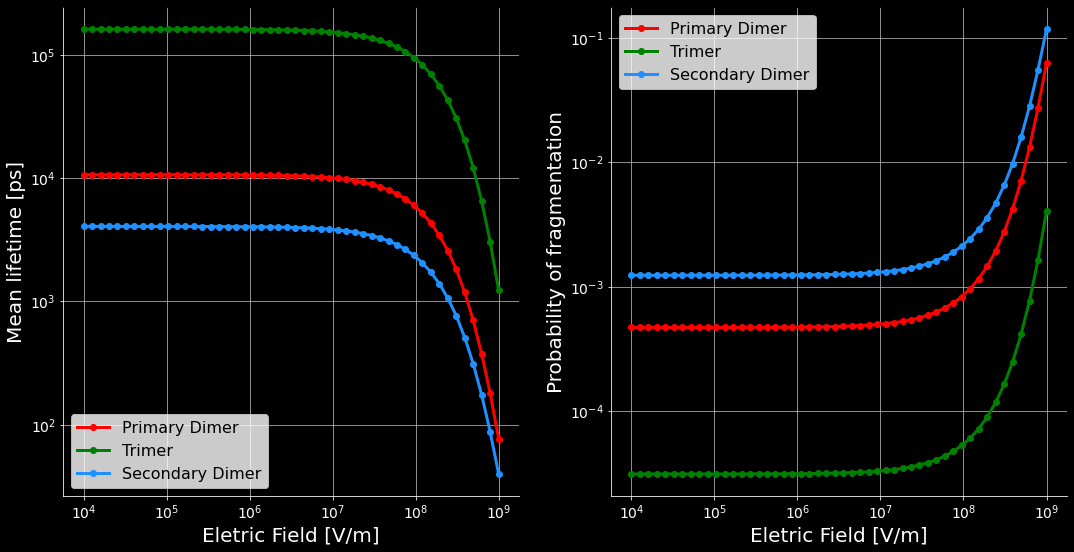

In [14]:
pows = np.linspace(4, 9)
efield = np.power(10, pows)  # V/M

####### Plot the mean life time as a function of the magnitude of the electric field ######

fig = plt.figure(figsize=(18,9), facecolor='k')
dt=5e-12
coeffs=np.array([2,3,5])
# Map coefficients to legend labels
label_map = {
    2: "Primary Dimer",
    3: "Trimer",
    5: "Secondary Dimer"
}
colors=['r','g','dodgerblue']


ax = fig.add_subplot(121, facecolor='k')
j=0
for coeff in coeffs:
    species=coeff*np.ones_like(efield)
    species=species.reshape(-1, 1)
    lifetime,_=prob_frag_compute(species,efield,dt)
    ax.plot(efield, lifetime*1e12 , 'o-',label=label_map[coeff],color=colors[j],linewidth=3) ; j=j+1
    ax.set_xlabel("Eletric Field [V/m]", color='w',fontsize=20)
    ax.set_ylabel("Mean lifetime [ps]", color='w',fontsize=20)
    ax.grid(True)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.tick_params(axis='x', colors='w', labelsize=14)  # Increase x-tick label size
ax.tick_params(axis='y', colors='w', labelsize=14)  # Increase y-tick label size
ax.legend(fontsize=16)


####### Plot the probability of fragmentation as a function of the magnitude of the electric field ######

ax = fig.add_subplot(122, facecolor='k')
j=0
for coeff in coeffs:
    species=coeff*np.ones_like(efield)
    species=species.reshape(-1, 1)
    _,frag=prob_frag_compute(species,efield,dt)
    ax.plot(efield, frag , 'o-',label=label_map[coeff],color=colors[j],linewidth=3) ; j=j+1
    ax.set_xlabel("Eletric Field [V/m]", color='w',fontsize=20)
    ax.set_ylabel("Probability of fragmentation", color='w',fontsize=20)
    ax.grid(True)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.tick_params(axis='x', colors='w', labelsize=14)  # Increase x-tick label size
ax.tick_params(axis='y', colors='w', labelsize=14)  # Increase y-tick label size
ax.legend(fontsize=16)
plt.savefig("fragmentation_model.png", format='png', bbox_inches='tight')


In [15]:
amu2kg= 1.66053906660 *1e-27 # converts amu to kg
mass_list=np.array([197.973,111.168,309.141,507.114])*amu2kg  # mass in kg: neutral, monomer, dimer, trimer 
m_neutral=mass_list[0]
m_mono=mass_list[1]
m_dim=mass_list[2]
m_trim=mass_list[3]


Next, we will write a function "fragmentaion_array" that takes the current state of the simulation (index, species mass, charge, position, velocity, and propability of fragmentation of each particle), and outputs the new state after fragmentation.

For each given particle $i$ we have its corresponding probability of fragmentation $P(i)$.

- For primary and secondary monomers and for neutrals, $P(i)=0$.
- For primary and secondary dimers and for trimers, $0<P(i)<1$. 

To produce fragmentation, we use a Monte Carlo approach as follows:
- At each timestep we choose a random number $n_{ran}$ between 0 and 1. 

- if $P(i)>n_{ran}$: Particle $i$ fragments at this timestep.

        if the particle is a trimer (3) replace it with a secondary dimer (5) and a neutral (0).
        if the particle is a secondary dimer (5) replace it with a secondary monomer (4) and a neutral (0).
        if the particle is a primary dimer (2) replace it with a secondary monomer (4) and a neutral (0).

- if $P(i)\leq n_{ran}$: Particle $i$ does not fragment at this timestep.

In [16]:
def fragmentation_array(idx,species,masses,charges,pos,vel,acc,frag):
    
    """Simulates the fragmentation of particles based on their probabilities of fragmentation using a Monte Carlo approach.
        if the particle is a trimer (3) replace it with a secondary dimer (5) and a neutral (0).
        if the particle is a secondary dimer (5) replace it with a secondary monomer (4) and a neutral (0).
        if the particle is a primary dimer (2) replace it with a secondary monomer (4) and a neutral (0).

    Args:
    - idx (np.array): An array of particle indices.
    - species (np.array): An array of species identifiers for the particles, where the species are encoded as integers.
    - masses (np.array): An array of masses for each particle.
    - charges (np.array): An array of charges for each particle.
    - pos (np.array): An array of positions for each particle.
    - vel (np.array): An array of velocities for each particle.
    - acc (np.array): An array of accelerations for each particle.
    - frag (np.array): An array of probabilities of fragmentation for each particle.

    Returns:
    Tuple containing updated arrays for idx, species, masses, charges, pos, vel, acc, and a counter indicating the number of fragmentations.        
    """

    np.random.seed(0)
    counter=0
    for i in range(len(frag)):
              
        if np.random.rand() < frag[i]:
            
            counter=counter+1
            
            idx=np.append(idx,np.max(idx)+1)
            species=np.append(species,0)
            masses=np.append(masses,m_neutral)
            charges=np.append(charges,0)
            pos = np.vstack((pos, pos[i]))
            vel = np.vstack((vel, vel[i]))
            acc = np.vstack((acc, acc[i]))
            
            if species[i]==2:
                #if primary Dimer
                species[i]=4 # becomes secondary monomer
                masses[i]=m_mono
                
            elif species[i]==3:
                #if Trimer
                species[i]=5 # becomes secondary Dimer
                masses[i]=m_dim
                
            elif species[i]==5:
                #if Secondary Dimer
                species[i]=4 # becomes secondary monomer
                masses[i]=m_mono

    return idx,species,masses,charges,pos,vel,acc,counter

----


## 4- Direct force algorithm to compute the forces applied on each particle 

Next, we need an algorithm that computes the forces applied on each particle within the plume at each time step. This is done using the direct force (DF) algorithm.

The force applied on each particle $i$ is the sum of two forces: (1) the electrostatic force due to the external electric field, and (2) and the Coulomb force due to the coulombic interaction between each pair of particles.

$$ \pmb{F}_i=q_i\,\pmb{E} \, + \, k \sum_{j \neq i} \frac{q_i\,q_j}{|\pmb{r_i-r_j}|^2}  \frac{\pmb{r_i-r_j}}{|\pmb{r_i - r_j}|}\, ,$$

where $\pmb{r_i}$ is the 3D coordinates of the position of the particle $i$.

To propagate the particles, we need to compute the acceleration of each particle: $\pmb{a_i}=\pmb{F_i}/m_i$.

- The acceleration due to the external electric field is computed with the function "compute_acc_laplace".

- The acceleration due to the Coulomb interactions is computed with the function "compute_acc_poisson".

Note: To avoid any division by 0, we add a softening parameter in the denominator :
$$ \pmb{F}_i=q_i\,\pmb{E} \, + \, k \sum_{j \neq i} \frac{q_i\,q_j}{|\pmb{r_i-r_j}|^2+\epsilon^2} \; \frac{\pmb{r_i-r_j}}{\sqrt{|\pmb{r_i - r_j}|^2+\epsilon^2}}\, ,$$

In [17]:
def compute_acc_laplace (E_array,pos,mass,charge):
    """Computes the acceleration of particles due to an external electric field.

    Args:
        E_array (np.array): An nx2 array of electric field values (Er, Ez) at the positions of the particles, 
                            where 'n' is the number of particles.
        pos (np.array): An nx3 array containing the Cartesian coordinates (x, y, z) of each particle.
        mass (np.array): An n-length array containing the mass of each particle.
        charge (np.array): An n-length array containing the charge of each particle.
    
    Returns:
        a_lap_cart(np.array): An nx3 array of accelerations in Cartesian coordinates (ax, ay, az) for each particle.
    """
    
    x = pos[:,0].copy()
    y = pos[:,1].copy()
    F_cyl=charge*E_array # nx2 array of Fr and Fz
    a_lap_cyl=F_cyl/mass  # nx2 array of ar and az
    #convert cylindrical coordinates to cartesian coordinates
    a_lap_cart = np.zeros((a_lap_cyl.shape[0], 3)) # define an array for the acceleration in the cartesian coordinates
    theta =np.arctan2(y, x) # Angle in the cylindrical coordinates formed by the point (x,y)
    a_lap_cart[:,0]=a_lap_cyl[:,0]*np.cos(theta) # a_cart(x) =a_cyl(r)*cos(theta)
    a_lap_cart[:,1]=a_lap_cyl[:,0]*np.sin(theta) # a_cart(x) =a_cyl(r)*cos(theta)
    a_lap_cart[:,2]=a_lap_cyl[:,1] # a_cart(z) =a_cyl(z)
    return a_lap_cart

To make the code run faster on Python, we use a just-in-time (JIT) compiler callled Numba. Numba translates Python code into efficient, low-level code in real-time.

If Numba is not installed on your machine, you can still run the same code (less efficiently) by commenting a few lines.

In [18]:
from numba import njit, prange, float64  # Comment this line if you don't have Numba installed

In [19]:
@njit('(float64[:,:], float64[:,:], float64[:,:],float64, float64)', cache=True, fastmath=True, parallel=True)  # Comment this line if you don't have Numba installed
def compute_acc_poisson(pos,mass,charge, k, softening):
    """ Computes the acceleration of particles due to the coulombic interactions between particles.
	Args:
		pos (type=np.array, size= Nx3): x, y, z positions of the N particles
		mass (type=np.array, size= Nx1): mass of the particles
        k (float): Coulomb constant
		softening (float): softening parameter

	Returns:
		acc (type=np.array, size= Nx3): ax, ay, az accelerations of the N particles
	"""
    n = pos.shape[0]

    # Copy the array view so for the next loop to be faster
    x = pos[:,0].copy()
    y = pos[:,1].copy()
    z = pos[:,2].copy()

    # Ensure mass is a contiguous 1D array (cheap operation)
    assert mass.shape[1] == 1
    contig_mass = mass[:,0].copy()
    
    # Ensure charge is a contiguous 1D array (cheap operation)
    assert charge.shape[1] == 1
    contig_charge = charge[:,0].copy()

    acc = np.empty((n, 3), pos.dtype)

    for i in prange(n): # use range instead of prange if you don't have Numba installed
        ax, ay, az = 0.0, 0.0, 0.0

        for j in range(n):
            dx = x[i] - x[j]  
            dy = y[i] - y[j]
            dz = z[i] - z[j]
            tmp = (dx**2 + dy**2 + dz**2 + softening**2) 
            factor = contig_charge[j] / (tmp * np.sqrt(tmp)) #we can use charge =1 as a scalar since we are in the positive mode
            ax += dx * factor
            ay += dy * factor
            az += dz * factor

        acc[i, 0] = k * contig_charge[i]/contig_mass[i] * ax
        acc[i, 1] = k * contig_charge[i]/contig_mass[i] * ay
        acc[i, 2] = k * contig_charge[i]/contig_mass[i] * az

    return acc


/Users/rafidbendimerad/opt/anaconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


----

## 5- Leap-frog algorithm to update the positions of the particles

To update the positions of the particles, we use the leapfrog integration. It operates by updating positions and velocities in a staggered manner: velocities are updated at half time steps (called kick), while positions are updated at full time steps (called drift). For our application we ue the kick-drift-kick sequence but we could also use the drift-kick-drift sequence. 

We use the leap frog alogorithm to integrate the positions because:
- The Leapfrog method is **symplectic**, meaning it **conserves the Hamiltonian** (total energy) of a system over long times, which is crucial for accurately simulating the dynamics of conservative systems, such as the N body problem.
- **Computational Efficiency**: It requires fewer computations per timestep compared to higher-order integrators like Runge-Kutta methods.
- The leapfrog method **conserves its good accuray even at larger timesteps** (compared to Runge-kutta). 


A good explanation of the leapfrog algorithm can be found here: https://www.youtube.com/watch?v=pVudb6-_FaM

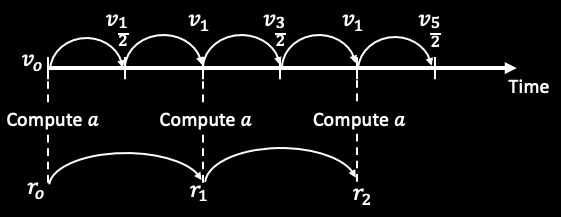

In [20]:
Image('leapfrog.png')

The acceleration is not systematically computed at each time step. Instead, the domain is divided into 3 regions:
- Region 1 ($d\leq5 \mu m$): Both the accelerations due to the electrostatic forces and the Coulomb interactions are calculated **each time step**.
- Region 2 ($5 \mu m <d \leq 250 \mu m$): The acceleration due to the electrostatic forces is calculated **each time step**. While the acceleration due to the interparticle interactions is calculated **each 10 timesteps**
- Region 3 ($250 \mu m <d $): Both accelerations are set to 0.

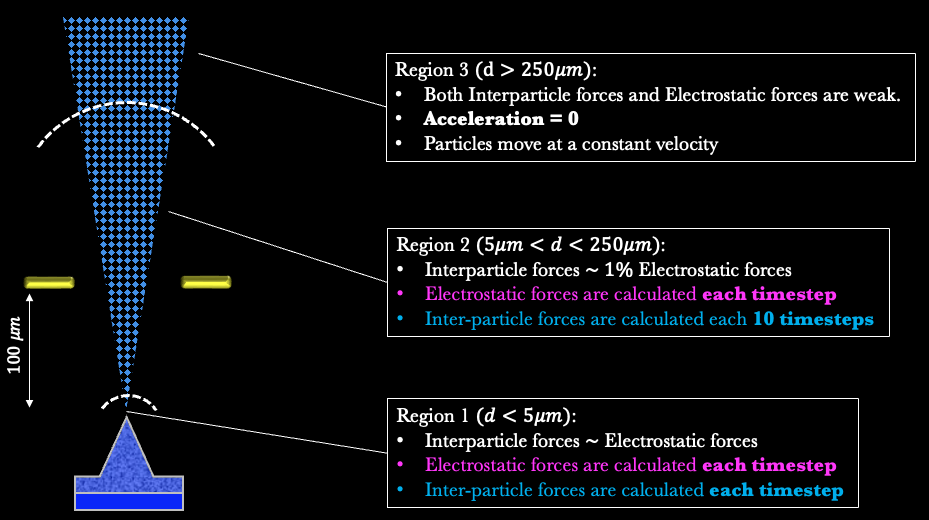

In [21]:
Image('domain_regions.png')

In [22]:
def leapfrog_kdk(pos, vel, acc, dt, mass, charge, k, softening, interp, current_step):
    """
    Performs the leapfrog integration method to update the positions and velocities of particles in a simulation.
    This method is based on the kick-drift-kick sequence.
    Args:
        pos (np.array of Nx3): Position x, y, and z of N particles.
        vel (np.array of Nx3): Velocity vx, vy, and vz of N particles.
        acc (np.array of Nx3): Acceleration ax, ay, and az of N particles.
        dt (float): Timestep.
        mass (np.array of N): Mass of N particles.
        k (float, optional): Coulomb constant.
        softening (float): Softening length.
        interp (LinearNDInterpolator): An instance of scipy.interpolate.LinearNDInterpolator.
        current_step (int): Current timestep.

    Returns:
        pos (np.array of Nx3): New position x, y, and z of N particles.
        vel (np.array of Nx3): New velocity vx, vy, and vz of N particles.
        acc (np.array of Nx3): New acceleration ax, ay, and az of N particles.
        E_array(np.array of Nx2):  Electric field values (Er, Ez) at the positions of the particles.
    """
    
    E_array=compute_efield (interp,pos)
    
    
    
    # Mask for particles whose mass is not m_neutral
    mask_neutral = mass[:, 0] != m_neutral  # Assuming masses is a 2D column vector
    
    # Mask for particles with z <= 5e-6
    mask1 = (pos[:,2] <= 5e-6) & mask_neutral
    # Mask for particles with 5e-6 < z <= 250e-6
    mask2 = (pos[:,2] > 5e-6) & (pos[:,2] <= 250e-6) & mask_neutral
    # Mask for particles with z > 250e-6
    mask3 = (pos[:,2] > 250e-6) & (pos[:,2] <= 1000e-6) & mask_neutral
    # Mask for region 1 and 2
    mask12=mask1 | mask2
    
    
    #print("mask1 shape:", mask1.shape)
    #print("mask2 shape:", mask2.shape)
    #print("mask12 shape:", mask12.shape)
    #print("pos shape:", pos.shape)
    #print("vel shape:", vel.shape)
    #print("acc shape:", acc.shape)
    #print("----")

    
    # (1/2) kick for particles with z <= 5e-6 or 5e-6 < z <= 250e-6
    vel[mask12] += acc[mask12] * dt/2.0
    
    # Drift for all particles
    pos += vel * dt
    
    # Update accelerations for particles with z <= 5e-6
    acc_poisson1 = compute_acc_poisson(pos[mask1], mass[mask1], charge[mask1], k, softening)
    #acc_laplace1 = compute_acc_laplace(interp, pos[mask1], mass[mask1], charge[mask1])
    acc_laplace1 = compute_acc_laplace(E_array[mask1],pos[mask1], mass[mask1], charge[mask1])
    acc[mask1] = acc_poisson1 + acc_laplace1
    
    # Update accelerations for particles with 5e-6 < z <= 250e-6
    if current_step % 10 == 0:
        acc_poisson2 = compute_acc_poisson(pos[mask2], mass[mask2], charge[mask2], k, softening)
    else:
        acc_poisson2 = np.zeros_like(pos[mask2])
        
    #acc_laplace2 = compute_acc_laplace(interp, pos[mask2], mass[mask2], charge[mask2])
    acc_laplace2=  compute_acc_laplace(E_array[mask2],pos[mask2], mass[mask2], charge[mask2])
    acc[mask2] = acc_poisson2 + acc_laplace2
    
    # Acceleration is null for particles with z > 250e-6
    acc[mask3] = 0.0
    
    # (1/2) kick for particles with z <= 5e-6 or 5e-6 < z <= 250e-6
    vel[mask12] += acc[mask12] * dt/2.0

    return pos, vel, acc ,E_array

----


The function "DF_nbody" uses all the previously defined functions to inject and propagate the particles. It takes a snapshot of the simulation each "kstep" steps.

if kstep=1, it takes a snapshot of the simulation each step. 

In [23]:
def DF_nbody(dt,N,prob,ri,zi,vri,vzi,Pneut,Pmono,Pdim,Ptrim,softening,k,interp,kstep):
    """Direct Force computation of the N-body problem in an electric field environment, incorporating particle injection,
        propagation, and fragmentation. This function simulates particle dynamics by calculating electrostatic and Coulomb forces,
        updating particle positions and velocities through leapfrog integration. Snapshots of the simulation are saved at intervals
        defined by the 'kstep' parameter.
 
    Args:
        dt (float): Timestep for the simulation.
        N (int): Number of injected particles to simulate.
        prob (float): Probability distribution function for initializing particle velocities and positions.
        ri, zi (float): Initial radial and axial positions for particle injection.
        vri, vzi (float): Initial radial and axial velocities for particle injection.
        Pneut, Pmono, Pdim, Ptrim (float): Probabilities for injecting neutrals, primary monomers, primary dimers, and primary trimers, respectively.
        softening (float): Softening parameter to avoid singularities in force calculations.
        k (float): Coulomb constant. 
        interp (LinearNDInterpolator): An instance of scipy.interpolate.LinearNDInterpolator.
        kstep (int): Interval at which simulation snapshots are saved. If kstep=1, a snapshot is saved at every timestep.

    Returns:
        species (np.array): Array of species identifiers for all particles at the end of the simulation.
        data_save (np.array): Array of saved snapshots of the simulation, containing particle indices, species, positions, velocities, electric fields,
                            and fragmentation probabilities.
        IC_copy (np.array): Copy of the initial conditions array for all particles.
        counters (np.array): Array counting the number of fragmented molecules at each timestep.
    """
    IC=IC_conditions (N,prob,ri,zi,vri,vzi,Pneut,Pmono,Pdim,Ptrim)
    IC_copy=np.copy(IC)
    init_pos=IC[:,0:3]
    init_vel=IC[:,3:6]
    init_species=IC[:,6]
    init_mass=IC[:,7]
    init_mass=init_mass.reshape(-1, 1)
    init_charge=IC[:,8]
    init_charge=init_charge.reshape(-1, 1)
    init_acc=np.zeros([1,3]) # initial acceleration of all the set of particles
    
    
    idx=np.array([0])
    species=np.copy(init_species[0:1])
    
    
    masses=np.copy(init_mass[0:1])
    masses=masses.reshape(-1, 1)
    
    charges=np.copy(init_charge[0:1])
    charges=charges.reshape(-1, 1)
    
    pos=np.copy(init_pos[0:1])
    vel=np.copy(init_vel[0:1])
    acc=np.copy(init_acc[0:1])
    
    counters=np.array([]) #count the number of fragmented molecules at each timestep
    
     
   
    data_save = np.empty(1, dtype=object) 
    
    # Ensure the directory exists
    if not os.path.exists("sim_data"):
        os.makedirs("sim_data")
        
        


	# Simulation Main Loop 


    for i in range(1,N):
        current_step=i-1
		# Run the leapfrog scheme:
        pos,vel,acc,E_array=leapfrog_kdk(pos,vel,acc,dt,masses,charges, k, softening,interp,current_step)
        
        E_mag = np.sqrt(E_array[:, 0]**2 + E_array[:, 1]**2)
        species=species.reshape(-1, 1)
        _,frag=prob_frag_compute(species,E_mag,dt)
        
        
        # save each kstep
        if np.mod(current_step,kstep)==0:
            data_save[0] = np.column_stack((idx,species,np.copy(pos),np.copy(vel),E_array,frag))
            filename = f"sim_data/positions_step_{current_step}.npy"
            np.save(filename, data_save)
        

        

        
        #Fragmentation
        idx,species,masses,charges,pos,vel,acc,counter =fragmentation_array(idx,species,masses,charges,pos,vel,acc,frag)
        
        counters=np.append(counters,counter)
        
         # Injection
        idx=np.append(idx,np.max(idx)+1)
        species=np.append(species,init_species[i])
        masses=np.append(masses,init_mass[i])
        masses=masses.reshape(-1, 1)
        charges=np.append(charges,init_charge[i])
        charges=charges.reshape(-1, 1)
        pos = np.vstack((pos, init_pos[i]))
        vel = np.vstack((vel, init_vel[i]))
        acc = np.vstack((acc, init_acc))
        
        
    return data_save, IC_copy,counters

-----

## 6- Run simulation

Now, we will run a simulation with 2000 particles.

In [24]:
N=3000  # total number of ejected particles 
dt=5e-12 # timestep in seconds
Pneut=0  # Percentage of injected neutrals = 0 (we don't inject neutrals)
Pmono=40 # Percentage of injected monomers
Pdim=40  # Percentage of injected dimers
Ptrim=20 # Percentage of injected trimers
kstep=50 # save the data in a separate file each kstep steps

softening=1e-12 
k=8.9875517923*1e9 #Coulomb constant

interp=triangulation (r,z,Er,Ez)


The simulation data are saved in the "sim_data" directory. 

We need to delete the old simulation files when we run a new simulation to avoid having 2 simulation files in the same folder.

In [25]:
!rm -f sim_data/*.npy  # For MAC and LINUX users
#!del /f /q sim_data\*.npy  # use this for Windows users

The next line runs the N body simulation. This should take less than a minute for 3000 particles.

In [26]:
pos_save,IC,counters = DF_nbody(dt,N,prob,ri,zi,vri,vzi,Pneut,Pmono,Pdim,Ptrim,softening,k,interp,kstep)


# The data is saved in the array "data_save" as follows:
# idx,species,x,y,z,vx,vy,vz,Er,Ez,frag

The snapshots of the simulation are saved in "sim_data/positions_step_{i}.npy". We need to make sure that the files are well sorted from i=0 to i=N, before making the animation.

In [27]:
directory_path = "sim_data"
# List all the .npy files in the directory
all_files = [f for f in os.listdir(directory_path) if f.endswith('.npy')]
# Sort the files based on the starting step (this assumes the naming convention you've used)
sorted_files = sorted(all_files, key=lambda x: int(x.split('_')[2].split('.')[0]))
# List to store data from each file
data_list = []
# Loop through each sorted file, load the data, and add it to the list
for filename in sorted_files:
    full_path = os.path.join(directory_path, filename)
    data = np.load(full_path, allow_pickle=True)
    data_list.append(data)
# Convert the list of arrays into a numpy array of arrays
all_data = np.array(data_list, dtype=object)
data_save = np.concatenate(all_data)

In [28]:
species=data_save[-1][:,1]
np.shape(species)
print("Injection of", N ,"particles")
print("Number of Primary Monomers =", np.sum(species==1))
print("Number of Primary Dimers =", np.sum(species==2))
print("Number of Primary Trimers =", np.sum(species==3))
print("Number of Secondary Monomers =", np.sum(species==4))
print("Number of Secondary Dimers =", np.sum(species==5))
print("Number of Neutrals =", np.sum(species==0))

Injection of 3000 particles
Number of Primary Monomers = 1205
Number of Primary Dimers = 533
Number of Primary Trimers = 0
Number of Secondary Monomers = 37
Number of Secondary Dimers = 0
Number of Neutrals = 1213


## 7- Visualization

## 2D animation

In [29]:
from matplotlib import colors as mcolors
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from matplotlib import rcParams

The next section of the code will save each frame of the 2D animation in "figures_2D".

If the frames already exist, we need to delete them before making a new animation.

In [30]:
!rm -f figures_2D/*.png # For MAC and LINUX users
#!del /f /q figures_2D\*.png  # use this for Windows users


In [31]:
label_map = {
    0: "Neutral",
    1: "Monomer",
    4: "Monomer",
    2: "Dimer",
    5: "Dimer",
    3: "Trimer"
}

color_map = {
    "Neutral": "white",
    "Monomer": "red",
    "Dimer": "limegreen",
    "Trimer": "royalblue"
}

alpha_map = {
    "Neutral": 0.9,
    "Monomer": 0.5,
    "Dimer": 0.5,
    "Trimer": 0.5
}

zorder_map = {
    "Neutral": 3,
    "Monomer": 1,
    "Dimer": 2,
    "Trimer": 0
}



for i in range(np.size(data_save)):
    fig = plt.figure(figsize=(6,8), facecolor='black')
    ax = fig.add_subplot(111, facecolor='black')
    #fig, ax = plt.subplots()
    # Plot the extractor grid
    p1 = (150, 100)
    p2 = (150, 130)
    p3 = (300, 100)
    p4 = (300, 130)
    width = p3[0]-p1[0]
    height = p2[1]-p1[1]
    rect1 = mpatches.Rectangle((p1[0],p1[1]), width, height, facecolor ='silver', alpha=0.5)
    p1 = (-150, 100)
    p2 = (-150, 130)
    p3 = (-300, 100)
    p4 = (-300, 130)
    width = p3[0]-p1[0]
    height = p2[1]-p1[1]
    rect2 = mpatches.Rectangle((p1[0],p1[1]), width, height, facecolor ='silver', alpha=0.5)

    #Plot the tip of the emitter
    r_tip=np.arange(0,75,1)
    d=100
    Rc=11
    eta0=np.power(1+Rc/d,-1/2)
    a=2*d*np.sqrt(1+Rc/d)
    z_tip=100-eta0*np.sqrt(np.power(a,2)/4+np.power(r_tip,2)/(1-np.power(eta0,2)))
    l, = ax.plot([],[])
    #xmax=np.nanmax(pos_save[:,0,-1])*1e6

    ax.clear()
    ax.axis([-300,300,-150,400])
    pos = data_save[i]
    xx = pos[:,2]*1e6
    zz = pos[:,4]*1e6
    subset_length = len(species) - 1
    xx_subset = xx[:subset_length]
    zz_subset = zz[:subset_length]
    
    col_list = [
    mcolors.to_rgba(color_map[label_map[spec]], alpha=alpha_map[label_map[spec]]) 
    for spec in species[:np.size(xx_subset)]
    ]

    zorder_list = [zorder_map[label_map[spec]] for spec in species[:np.size(xx_subset)]]

    ax.scatter(xx_subset, zz_subset, s=5, c=col_list,marker='.')

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    plt.fill_between(r_tip+0.1, z_tip,-150, color='skyblue', alpha=0.5)
    plt.fill_between(-r_tip-0.1, z_tip,-150, color='skyblue', alpha=0.5)
    plt.xlabel("r ($\mu m$)",fontsize=14,color='white')
    plt.ylabel("z ($\mu m$)",fontsize=14,color='white')
    plt.title('Number of injected particles: %i' %(kstep*i), fontsize=16, color='w')
    ax.tick_params(axis='both', colors='white')
    # Set spine colors
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')


    #Add legends

    unique_labels = ["Neutral", "Monomer", "Dimer", "Trimer"]

    for label in unique_labels:
        plt.scatter([], [], color=mcolors.to_rgba(color_map[label], alpha=alpha_map[label]), s=50, label=label)

    # Create the legend first
    leg = plt.legend(loc='lower right',fontsize=14)
    # Set the background color to black
    leg.get_frame().set_facecolor('black')
    # Set the text color of each legend text item to white
    for text in leg.get_texts():
        text.set_color('white')

    # Display the legend
    #plt.legend(loc='best')
    plt.savefig(f'figures_2D/2D_{i}.png', dpi=100)
    plt.close(fig)

The next sectoin of the code reads each frame in "figures_2D" and produces a GIF.

In [32]:
from PIL import Image
from IPython.display import display, Image as IPImage

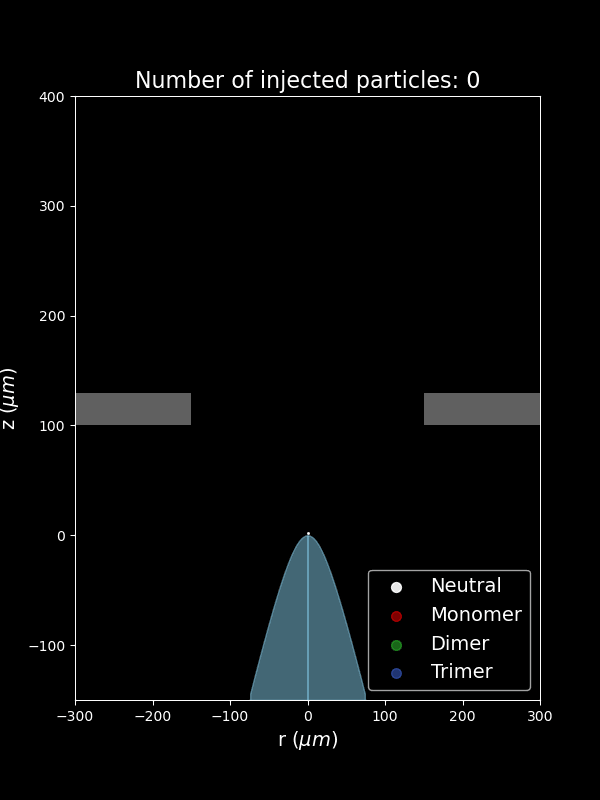

In [33]:

# Set the directory path for your images
directory = 'figures_2D'

# Load images
images = []
for file_name in sorted(os.listdir(directory)):
    if file_name.endswith('.png'):
        file_path = os.path.join(directory, file_name)
        images.append(Image.open(file_path))

# Sort images based on filenames
images = sorted(images, key=lambda x: int(x.filename.split('_')[-1].split('.')[0]))

# Save the images as a GIF
gif_path = 'animation2D.gif'
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)

# Display the GIF in Jupyter Notebook
with open(gif_path, 'rb') as file:
    display(IPImage(file.read()))


## 3D animation

The next section of the code will save each frame of the 3D animation in "figures_3D".

If the frames already exist, we need to delete them before making a new animation.

In [34]:
!rm -f figures_3D/*.png # For MAC and LINUX users
#!del /f /q figures_3D\*.png  # use this for Windows users

In [35]:
label_map = {
    0: "Neutral",
    1: "Monomer",
    4: "Monomer",
    2: "Dimer",
    5: "Dimer",
    3: "Trimer"
}

color_map = {
    "Neutral": "white",
    "Monomer": "red",
    "Dimer": "limegreen",
    "Trimer": "royalblue"
}

alpha_map = {
    "Neutral": 0.9,
    "Monomer": 0.5,
    "Dimer": 0.5,
    "Trimer": 0.5
}

zorder_map = {
    "Neutral": 3,
    "Monomer": 1,
    "Dimer": 2,
    "Trimer": 0
}


# Plot the emitter tip

r_tip = np.arange(0, 75, 10)
d = 100
Rc = 11
eta0 = np.power(1 + Rc / d, -1 / 2)
a = 2 * d * np.sqrt(1 + Rc / d)
z_tip = 100 - eta0 * np.sqrt(np.power(a, 2) / 4 + np.power(r_tip, 2) / (1 - np.power(eta0, 2)))

thetas = np.linspace(0, 2 * np.pi, 100)  # 360 degrees
rr, th = np.meshgrid(r_tip, thetas)
X3 = rr * np.cos(th)
Y3 = rr * np.sin(th)
Z3 = 100 - eta0 * np.sqrt(np.power(a, 2) / 4 + np.power(rr, 2) / (1 - np.power(eta0, 2)))

# Parameters for the circle
radius_cicle = 150
center_cicle = (0, 0, 100)
x_cicle = center_cicle[0] + radius_cicle * np.cos(thetas)
y_cicle = center_cicle[1] + radius_cicle * np.sin(thetas)
z_cicle = np.full_like(x_cicle, center_cicle[2])  # z-coordinates remain constan
z_cicle2 = np.full_like(x_cicle, center_cicle[2]-10)  
z_cicle3 = np.full_like(x_cicle, center_cicle[2]-20)  


pos_index=np.where(y_cicle>0)

for i in range(np.size(data_save)):
    fig = plt.figure(figsize=(6,6), dpi=80, facecolor='k')
    ax = plt.axes([0.1, 0.1, 5/6, 5/6], projection='3d', facecolor='black')
    grid = plt.GridSpec(1, 1, wspace=0.0, hspace=0.3)
    ax.tick_params(colors='white')
    ax.set(xlim=(-300, 300), ylim=(-300, 300),zlim=(-150, 250))
    ax.view_init(elev=15, azim=70)

 

    ax.plot_surface(X3, Y3, Z3, color='skyblue', alpha=1)

    current_pos = data_save[i]
    xx = current_pos[:,2]*1e6
    yy = current_pos[:,3]*1e6
    zz = current_pos[:,4]*1e6


    col_list = [
        mcolors.to_rgba(color_map[label_map[spec]], alpha=alpha_map[label_map[spec]]) 
        for spec in species[:np.size(xx)]
        ]
    ax.scatter(xx,yy,zz,s=5, c=col_list)
    
    ax.plot(x_cicle, y_cicle, z_cicle, alpha=1, color="k",linewidth=10)
    ax.plot(x_cicle, y_cicle, z_cicle2, alpha=1, color="k",linewidth=10)
    
    ax.plot(x_cicle[pos_index] ,y_cicle[pos_index], z_cicle[pos_index], alpha=1, color="k",linewidth=10,zorder=10)
    ax.plot(x_cicle[pos_index] ,y_cicle[pos_index], z_cicle2[pos_index], alpha=1, color="k",linewidth=10,zorder=10)
    
    
    ax.plot_surface(X3, Y3, Z3, color='skyblue', alpha=1)
    
    
    
    ax.set(xlim=(-300, 300), ylim=(-300, 300),zlim=(-150, 250))
    plt.title('Number of injected particles: %i' %(kstep*i), fontsize=16, color='w')
    #plt.legend(handles=[mono_patch, dim_patch,trim_patch], loc='upper right')
    ax.set_aspect('auto', 'box')
    ax.set_xlabel('X axis ($\mu m$)', color='white')
    ax.set_ylabel('Y axis ($\mu m$)', color='white')
    ax.set_zlabel('Z axis ($\mu m$)', color='white')
    ax.view_init(elev=12, azim=70)
    plt.savefig(f'figures_3D/3D_{i}.png', dpi=100)
    plt.close()

The next sectoin of the code reads each frame in "figures_3D" and produces a GIF.

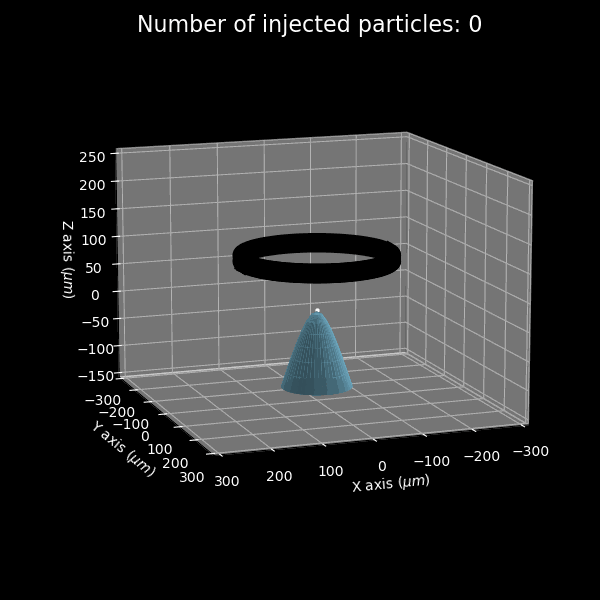

In [36]:

# Set the directory path for your images
directory = 'figures_3D'

# Load images
images = []
for file_name in sorted(os.listdir(directory)):
    if file_name.endswith('.png'):
        file_path = os.path.join(directory, file_name)
        images.append(Image.open(file_path))

# Sort images based on filenames
images = sorted(images, key=lambda x: int(x.filename.split('_')[-1].split('.')[0]))

# Save the images as a GIF
gif_path = 'animation3D.gif'
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)

# Display the GIF in Jupyter Notebook
with open(gif_path, 'rb') as file:
    display(IPImage(file.read()))


____
____